# Python Basics


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

csvFileAddress = input('Enter CSV File Address:')

DJ = pd.read_csv(csvFileAddress,delim_whitespace=True)

DJ.insert(7, '<ISGREEN>',value=0)
DJ.insert(8, '<SIZE>',value=0)
DJ.insert(9, '<VOLATILITY>',value=0)

DJ['<ISGREEN>'] =  DJ['<CLOSE>'] > DJ['<OPEN>']
DJ['<SIZE>'] =  DJ['<CLOSE>'] - DJ['<OPEN>']
DJ['<VOLATILITY>'] =  DJ['<HIGH>'] - DJ['<LOW>']

DJ.drop(['<HIGH>','<LOW>','<TICKVOL>','<VOL>','<SPREAD>'],axis=1,inplace=True)



In [61]:
timeFrame = (int(DJ.iloc[1][1][1])-int(DJ.iloc[0][1][1]) )*60 + (int(DJ.iloc[1][1][3:5])-int(DJ.iloc[0][1][3:5]))
CandlesInDay = 24 * (60//timeFrame)

In [62]:
def candleToTime(j):
    minuteMult = CandlesInDay//24
    k=j//minuteMult
    sth=timeFrame*(j%minuteMult)
    return '{:02d}:{:02d}:00'.format(k,sth)

uniqueDays = DJ.drop_duplicates(subset='<DATE>')
uniqueDays = pd.DataFrame(uniqueDays)

uniqueDaysCount=uniqueDays.shape[0]


newDF = pd.DataFrame(columns=['<DATE>','<TIME>','<OPEN>','<CLOSE>','<ISGREEN>','<SIZE>','<VOLATILITY>'])




for i in range(uniqueDaysCount):

    if(i%120==0):
        print((int(i/uniqueDaysCount*10000))/100 , '%')
    for j in range(CandlesInDay):
        newDF.loc[(i*CandlesInDay)+j]=[uniqueDays.iloc[i][0],candleToTime(j),0,0,0,0,0]


0.0 %


In [63]:
newestDF = newDF.merge(DJ,on=['<DATE>','<TIME>'],how='left')

newestDF.drop(columns=['<OPEN>_x','<CLOSE>_x','<SIZE>_x','<VOLATILITY>_x','<ISGREEN>_x','<CLOSE>_y','<OPEN>_y'],inplace=True)
newestDF['<ISGREEN>_y'] = newestDF['<ISGREEN>_y'].fillna(0)
newestDF['<SIZE>_y'] = newestDF['<SIZE>_y'].fillna(0)
newestDF['<VOLATILITY>_y'] = newestDF['<VOLATILITY>_y'].fillna(0)



,<DATE>,<TIME>,<ISGREEN>_y,<SIZE>_y,<VOLATILITY>_y
0,2022.02.13,00:00:00,True,22.31,24.24
1,2022.02.13,00:20:00,True,9.64,34.09
2,2022.02.13,00:40:00,True,6.24,21.85
3,2022.02.13,01:00:00,False,-1.63,10.77
4,2022.02.13,01:20:00,False,-13.36,14.52
...,...,...,...,...,...
5683,2022.05.02,22:20:00,True,21.01,27.94
5684,2022.05.02,22:40:00,True,2.82,21.16
5685,2022.05.02,23:00:00,True,0.75,5.83
5686,2022.05.02,23:20:00,0,0.00,0.00


In [64]:
list = []
for i in range(len(newestDF)):
    date = newestDF.iloc[i][0]
    time = newestDF.iloc[i][1]
    isGreen = newestDF.iloc[i][2]
    size = newestDF.iloc[i][3]
    volatility = newestDF.iloc[i][4]
    
    list.append([date, time, isGreen, size, volatility])


In [65]:
days = []
for i in range(uniqueDaysCount): 
    days.append(list[i*CandlesInDay: CandlesInDay*(i+1)])


In [78]:
avgMultiplier = float(input('Only calculate candles bigger than X times the average (def=1) :' )or '1')

def eachDayMatrix(day):
    
    avgCandleBodySize=0
    avgCandleVolatility=0

    for i in range(len(day)):
        avgCandleBodySize+=abs(day[i][3])
        avgCandleVolatility+=abs(day[i][4])
    
    avgCandleBodySize/=len(day)
    avgCandleVolatility/=len(day)

    ansMatrix = np.zeros((CandlesInDay,CandlesInDay),dtype=int)
    countMatrix = np.zeros((CandlesInDay,CandlesInDay),dtype=int)
    for i in range(len(day)) : 
        for j in range (i,len(day)):
            if abs(day[i][4])> avgCandleVolatility*avgMultiplier and abs(day[i][3])> avgCandleBodySize*avgMultiplier and abs(day[j][4])>0 :
                countMatrix[i][j] += 1
                ansMatrix[i][j]=1 if not(day[i][2] ^ day[j][2]) else -1
                continue
            ansMatrix[i][j]=0
            

    return [ansMatrix,countMatrix]

ansVector = []
countVector = []
for i in range(len(days)):
    countVector.append(eachDayMatrix(days[i])[1])
    ansVector.append(eachDayMatrix(days[i])[0])

final = np.sum(ansVector, axis=0)
countFinal = np.sum(countVector, axis=0)
# final-=len(days)//2
# plt.imshow(final)



<AxesSubplot:>

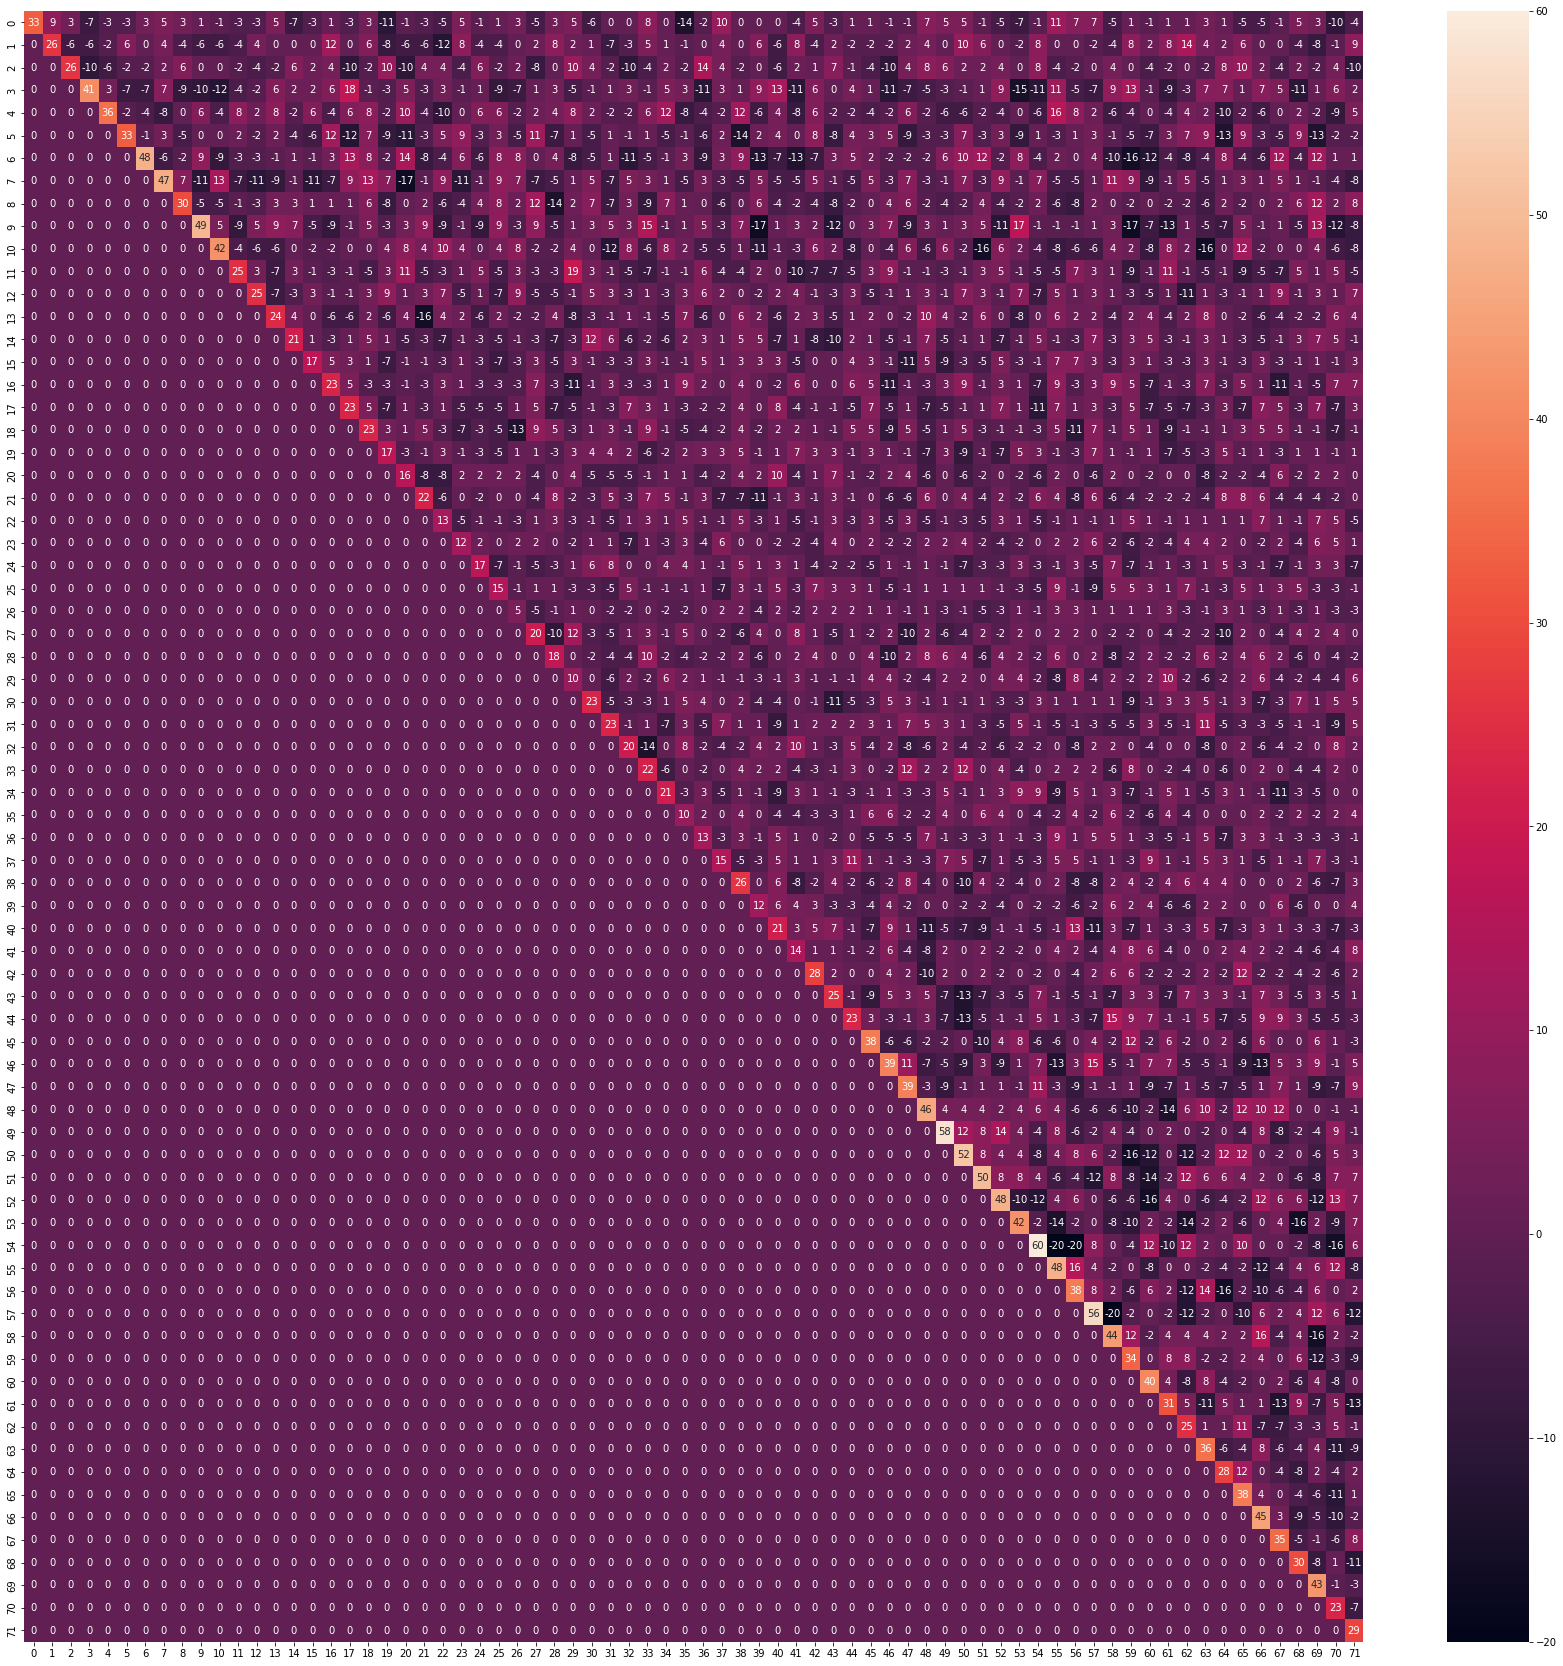

In [75]:
plt.figure(figsize=(30,30))
sns.heatmap(final,annot=True,)


<AxesSubplot:>

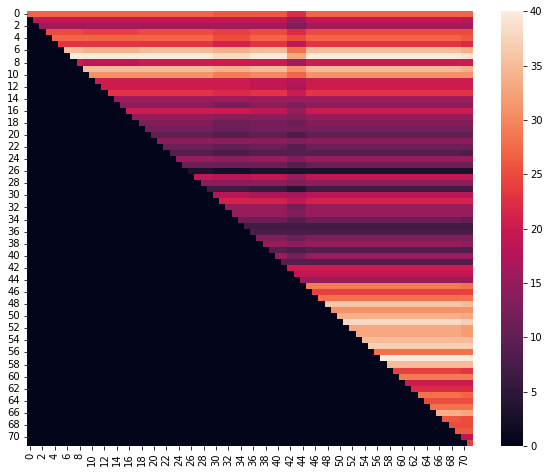

In [79]:
plt.figure(figsize=(10,8))
sns.heatmap(countFinal,annot=False,)


In [83]:
# float(input('Bias:')) 
biasPercentage = 70

consecutiveAndClose = True
consecutiveOnly = False
percentTimesCountedAtLeastMoreThan = 40

print('Averages Multiplier :',avgMultiplier)
for i in range(len(final)):
    for j in range (i,len(final)):
        percentageHigherThanAvg = int(countFinal[i][j]/uniqueDaysCount *10000) /100
        if( percentageHigherThanAvg < percentTimesCountedAtLeastMoreThan ):
            continue
        prob = int(abs(final[i][j]) / countFinal[i][j] *10000)/100 + 50.00
        if (biasPercentage<prob<100)and (not i==j):
            if(j-i==1):
                print(f"{i}-{j}",f"{candleToTime(i)}-{candleToTime(j)}",f"{prob}% ++",percentageHigherThanAvg,'Consecutive') if final[i][j]>=0 else print(f"{i}-{j}",f"{candleToTime(i)}-{candleToTime(j)}",f"{prob}% --",percentageHigherThanAvg,'Consecutive')
                continue
            if(j-i <= 120/timeFrame) and (not consecutiveOnly):
                print(f"{i}-{j}",f"{candleToTime(i)}-{candleToTime(j)}",f"{prob}% ++",percentageHigherThanAvg,'Close') if final[i][j]>=0 else print(f"{i}-{j}",f"{candleToTime(i)}-{candleToTime(j)}",f"{prob}% --",percentageHigherThanAvg,'Close')
                continue
            if not(consecutiveAndClose or consecutiveOnly): 
                print(f"{i}-{j}",f"{candleToTime(i)}-{candleToTime(j)}",f"{prob}% ++",percentageHigherThanAvg) if final[i][j]>=0 else print(f"{i}-{j}",f"{candleToTime(i)}-{candleToTime(j)}",f"{prob}% --",percentageHigherThanAvg)




Averages Multiplier : 1.0
6-10 02:00:00-03:20:00 79.41% -- 43.03 Close
7-8 02:20:00-02:40:00 75.0% ++ 50.63 Consecutive
7-10 02:20:00-03:20:00 85.0% ++ 50.63 Close
48-51 16:00:00-17:00:00 72.22% ++ 45.56 Close
51-53 17:00:00-17:40:00 76.31% ++ 48.1 Close
51-57 17:00:00-19:00:00 71.05% -- 48.1 Close
52-54 17:20:00-18:00:00 77.27% -- 41.77 Close
53-58 17:40:00-19:20:00 71.21000000000001% -- 41.77 Close
53-59 17:40:00-19:40:00 83.33% -- 41.77 Close
55-56 18:20:00-18:40:00 85.13% ++ 46.83 Consecutive
57-62 19:00:00-20:40:00 85.0% -- 50.63 Close
58-59 19:20:00-19:40:00 75.71000000000001% ++ 44.3 Consecutive
66-71 22:00:00-23:40:00 71.21000000000001% -- 41.77 Close
